<a href="https://colab.research.google.com/github/mariustsui/antarctica/blob/main/TabsTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#In colab:
!pip install catboost
!pip install shap

In [ ]:
import pandas as pd
import numpy as np
import catboost
import random
import time
print('catboost version:', catboost.__version__)
from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RepeatedKFold, GridSearchCV, cross_validate, StratifiedShuffleSplit

import seaborn as sns


catboost version: 1.2.2


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

#Set display all rows and columns for dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Set default plot labels
params = {'axes.titlesize':'8',
          'xtick.labelsize':'8',
          'ytick.labelsize':'8'}
matplotlib.rcParams.update(params)

random_state = 28

In [ ]:

from google.colab import drive, output, data_table

#Mount google drive for files
drive.mount('/content/gdrive')

#For a 'shared drive' - create a shortcut named to 'My Drive'
#csv files are written to this folder
inputdata_dir = '/content/gdrive/My Drive/Colab Notebooks/NZTABS/'
outputdata_dir = '/content/gdrive/My Drive/Colab Notebooks/NZTABS/'

# below line set style for tables but does not work with caller notebook
# %load_ext google.colab.data_table

output.clear()
#If colab:
#dfAll = pd.read_csv('https://docs.google.com/spreadsheets/d/1BtHc3GYLIbqJMFKQoItZ4iMqBuVGOLr1/export?format=csv&gid=1695701939')

#If local:
# dfAll = pd.read_csv(r'C:\00Files\Research\Antarctica\000 NZ Tabs Data\TestData1.csv')
dfAll = pd.read_excel(outputdata_dir+ 'NZTABOriginalandNewValleysMerged3' + '.xlsx')



In [ ]:
dfAll.head(10)

,UNIQUECODE,FIELDID,SORTID,GEOLOGY,ASPECTDIRECTION,TILE,MICROHABITATNUMBER,MICROHABITATCL1,LAT,LONG,ELEVATION,SLOPE,SLOPEMEAN,ASPECTNUMBER,DegreesFromNorth,WETNESS,WETMEAN,SNOW,TEMPERATURE,NPERCENT,CPERCENT,CN,AGGSOILWATER,ACTIVEWATER,AGGCONDUCTIVITY,AGGPH,AGGCYANOCOVERAGE,CYANOPresenceAbsence,AGGMOSSCOVERAGE,MOSSPresenceAbsence,AGGLICHENCOVERAGE,LICHENPresenceAbsence,AGGSPRINGTAILS,SPRINGTAILSPresenceAbsence,AGGMITES,MITESPresenceAbsence,AGGATP,DNACONCENTRATION,BACTS001,BACTJ001,BACTS0001,BACTJ0001,CYANOS001,CYANOJ001,CYANOS0001,CYANOJ0001,FUNGALS001,FUNGALJ001,FUNGALS0001,FUNGALJ0001,AGGNEMATODESLIVETOTAL,AGGROTIFERS,AGGTARDIGRADES,SCOTTNEMAMLIVE,SCOTTNEMAMDEAD,SCOTTNEMAFLIVE,SCOTTNEMAFDEAD,SCOTTNEMAJUVLIVE,SCOTTNEMAJUVDEAD,SCOTTNEMAADULTSLIVEANDDEAD,SCOTTNEMAJUVLIVEANDDEAD,SCOTTNEMATOTALLIVE,SCOTTNEMATOTALDEAD,SCOTTNEMATOTALLIVEANDDEAD,EUDORYLAIMUSMLIVE,EUDORYLAIMUSMDEAD,EUDORYLAIMUSFLIVE,EUDORYLAIMUS:FDEAD,EUDORYLAIMUSJUVLIVE,EUDORYLAIMUS:JUVDEAD,EUDORYLAIMUSADULTLIVEANDDEAD,EUDORYLAIMUSJUVLIVEANDDEAD,EUDORYLAIMUSTOTALLIVE,EUDORYLAIMUSTOTALDEAD,EUDORYLAIMUSTOTALLIVEANDDEAD,PLECTUSFLIVE,PLECTUSFDEAD,PLECTUSJUVLIVE,PLECTUSJUVDEAD,PLECTUSADULTSLIVEANDDEAD,PLECTUSJUVLIVEANDDEAD,PLECTUSTOTALLIVE,PLECTUSTOTALDEAD,PLECTUSTOTALLIVEANDDEAD,ROTIFERSTOTAL,TARDIGRADESTOTAL,NEMATODESLIVE,NEMATODESDEAD,NEMATODESLIVEANDDEAD
0,521.0,481-3,481-3,Alluvial,Zero,481,3,Ridge.Crest,-78.093300,163.835900,163.425000,3.2802,4.6101,163.7674,163.7674,7.726200,9.268900,0.3957,1.6217,0.022309,0.256610,11.502373,28.156276,1,0.09,8.98,20.0,1,0.0,0,0.0,0,0.0,0,200,1,99864,9.69,8.0,0.7181,28.0,0.6513,13.0,0.8728,49.0,0.7026,6.0,0.5551,26.0,0.4184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,NaN,TV0025,NaN,NaN,NaN,NaN,NaN,NaN,-77.516100,163.574067,435.683136,9.0000,12.0000,311.0000,49.0000,4.275148,4.416477,NaN,-8.3700,NaN,NaN,NaN,24.250000,1.12,0.1127,8.6,0.0,0,0.0,0,0.0,0,0.0,0,150,1,6869,533.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8596.738050,13392.028400,1267.149250,24.846064,0.000000,2211.299670,397.537020,6360.592320,1614.994140,2633.682760,7975.586460,8596.738050,2012.531160,10609.269200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13392.028400,1267.149250,8596.738050,2012.531160,10609.269200
2,NaN,TV0160,NaN,NaN,NaN,NaN,NaN,NaN,-77.573183,163.117333,654.211304,5.0000,13.0000,112.0000,112.0000,4.953923,4.307655,NaN,-7.3100,NaN,NaN,NaN,0.630000,1.01,0.1368,7.99,0.0,0,0.0,0,0.0,0,0.0,0,100,1,2814,663.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.179278,0.000000,0.000000,30.179278,0.000000,0.000000,0.000000,0.000000,0.000000,30.179278,0.000000,30.179278,0.000000,30.179278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,30.179278,0.000000,30.179278
3,11034.0,9041B,no K020 sheet data,NaN,NaN,NaN,NaN,NaN,-78.133850,163.843490,294.765411,4.0000,12.0000,196.0000,164.0000,6.299373,4.233989,NaN,-6.7000,0.001600,0.018400,11.400000,7.551768,0.85,0.0909,9.32,0.0,0,0.0,0,0.0,0,0.0,0,64,1,27157,648.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.684446,0.000000,0.000000,55.391000,7.551768,0.000000,0.000000,0.000000,0.000000,10.684446,0.000000,0.000000,10.684446,10.684446,0.000000,10.684446,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,10.684446,0.000000,10.684446
4,454.0,386-3,386-3,Granite,West,386,3,Pond,-78.075817,163.939667,866.287700,17.7067,11.2783,27.1997,27.1997,6.165100,7.915300,0.4105,-1.8574,0.002182,0.031936,14.634332,10.167270,0.998,0.05,9.07,0.0,0,0.0,0,1.0,1,1.0,1,56,1,9301,1.23,23.0,0.88

In [ ]:
# all_features = list(dfAll.columns)[9:10] + list(dfAll.columns)[18:]
# all_features

all_features = [
# "GEOLOGY",
# "ASPECT.DIRECTION",
# "TILE",
# "MICROHABITAT.NUMBER",
# "MICROHABITAT.CL1",
# "LAT",
# "LONG",
"ELEVATION",
"SLOPE",
"SLOPEMEAN",
# "ASPECTNUMBER",
"DegreesFromNorth",
"WETNESS",
"WETMEAN",
# "SNOW",
"TEMPERATURE",
# "N.PERCENT",
# "C.PERCENT",
# "CN",
# "AGG.SOIL.WATER",
# "ACTIVE.WATER",
# "AGG.CONDUCTIVITY",
# "AGG.PH",
"CYANOPresenceAbsence",
"MOSSPresenceAbsence",
"LICHENPresenceAbsence",
"SPRINGTAILSPresenceAbsence",
"MITESPresenceAbsence"
# "AGGCYANOCOVERAGE",
# "AGGMOSSCOVERAGE",
# "AGGLICHENCOVERAGE",
# "AGGSPRINGTAILS",
# "AGGMITES"
]

all_features1 = [
# "GEOLOGY",
# "ASPECT.DIRECTION",
# "TILE",
# "MICROHABITAT.NUMBER",
# "MICROHABITAT.CL1",
# "LAT",
# "LONG",
"ELEVATION",
"SLOPE",
"SLOPEMEAN",
# "ASPECTNUMBER",
"DegreesFromNorth",
"WETNESS",
# "WETMEAN",
# "SNOW",
"TEMPERATURE"
# "N.PERCENT",
# "C.PERCENT",
# "CN",
# "AGG.SOIL.WATER",
# "ACTIVE.WATER",
# "AGG.CONDUCTIVITY",
# "AGG.PH",
# "AGG.CYANO.COVERAGE",
# "AGG.MOSS.COVERAGE",
# "AGG.LICHEN.COVERAGE",
# "AGG.SPRINGTAILS",
# "AGG.MITES"
]


In [ ]:
#Reset dataframe
df = dfAll.reset_index()


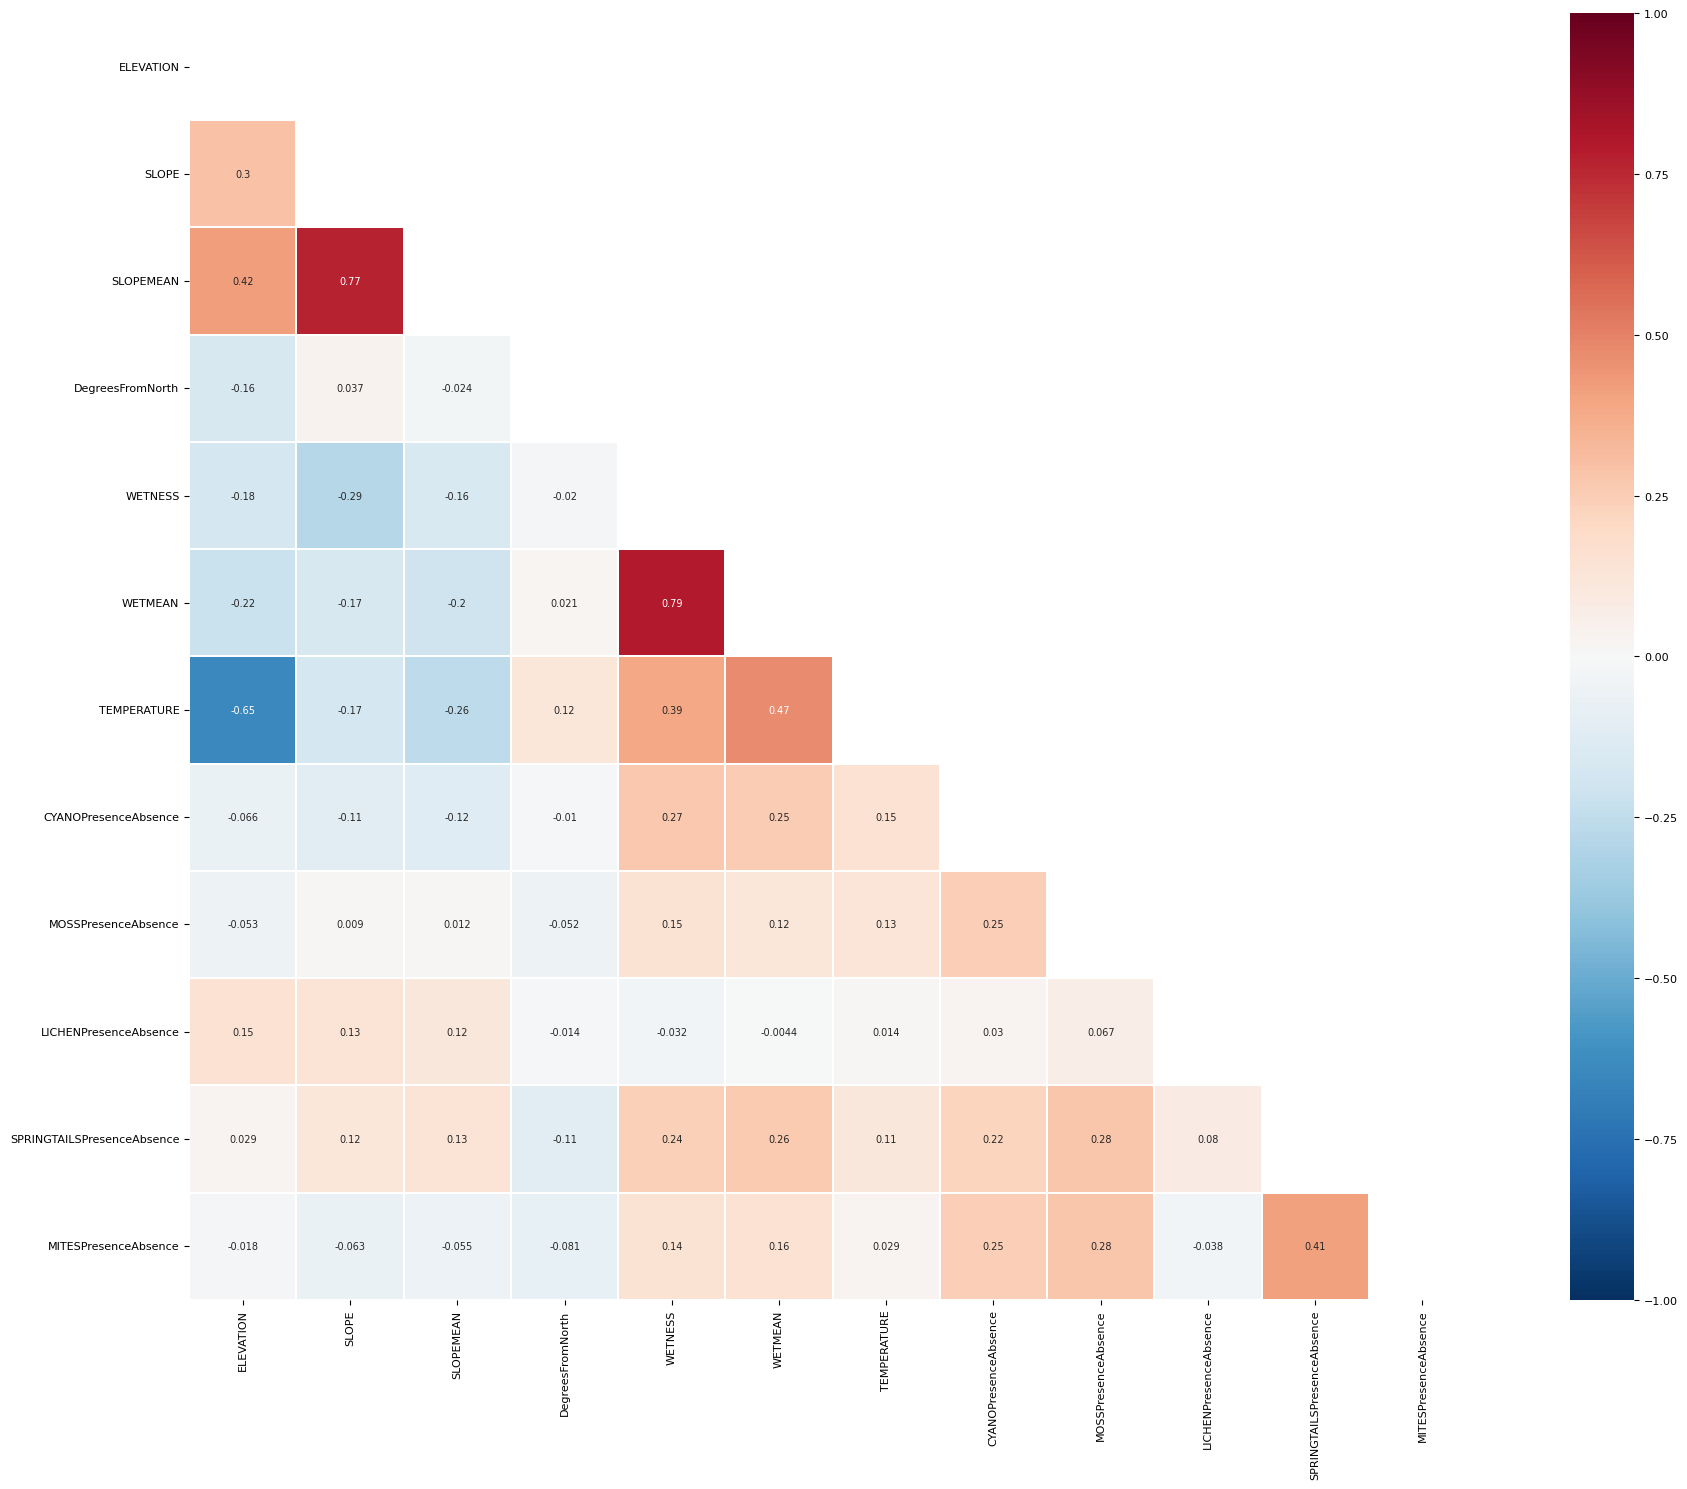

In [ ]:
variable_dataframe = df[all_features]
corr_filtered = variable_dataframe.corr()
plt.figure(figsize=(20, 15))

matrix = np.triu(corr_filtered)

sns.heatmap(corr_filtered,
            cmap='RdBu_r', vmax=1.0, vmin=-1.0, linewidths=0.05,
            annot=True, annot_kws={"size": 7}, square=True, mask=matrix);

plt.tight_layout()

In [ ]:
#Example: No CV - Catboost regressor
# target = "AGGCYANOCOVERAGE"
# target = "AGGMOSSCOVERAGE"
# target = "AGGLICHENCOVERAGE"
# target = "AGGSPRINGTAILS"
# target = "AGGMITES"
target = "CYANOPresenceAbsence"
# target = "MOSSPresenceAbsence"
# target = "LICHENPresenceAbsence"
# target = "SPRINGTAILSPresenceAbsence"
# target = "MITESPresenceAbsence"



train, test = train_test_split(df, test_size=0.2)

train_df = train.copy().reset_index()

y_train = train_df[[target]].to_numpy().ravel()
X_train = train_df[all_features1]

val_df = test.copy().reset_index()

y_val = val_df[[target]].copy().to_numpy().ravel()
X_val = val_df[all_features1]

test_df = test.copy().reset_index()

y_test = test_df[[target]].copy().to_numpy().ravel()
X_test = test_df[all_features1]



params = {'iterations':10000,
        'learning_rate':0.05,
        'depth':4,
        'loss_function':'MAE',
        'eval_metric':'R2',
        'random_seed':random_state,
        'metric_period':200,
        'od_type':"Iter",
        'od_wait':1000,
        'verbose':True,
        'use_best_model':True}


model_regressor = CatBoostRegressor(**params)

model_regressor.fit(X_train, y_train,
          eval_set=(X_val, y_val),
          use_best_model=True,
          plot= True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: -0.0859657	test: -0.1202143	best: -0.1202143 (0)	total: 1.37ms	remaining: 13.7s
200:	learn: 0.1515581	test: -0.0792625	best: -0.0611308 (91)	total: 159ms	remaining: 7.73s
400:	learn: 0.1965265	test: -0.0977171	best: -0.0611308 (91)	total: 320ms	remaining: 7.67s
600:	learn: 0.2218789	test: -0.0917214	best: -0.0611308 (91)	total: 461ms	remaining: 7.21s
800:	learn: 0.2388801	test: -0.0898707	best: -0.0611308 (91)	total: 608ms	remaining: 6.98s
1000:	learn: 0.2513183	test: -0.0828141	best: -0.0611308 (91)	total: 752ms	remaining: 6.76s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = -0.06113083161
bestIteration = 91

Shrink model to first 92 iterations.


In [ ]:
pred = model_regressor.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

# model_regressor.plot_tree(
#     tree_idx=2725,
#     )

Testing performance
RMSE: 0.32
R2: -0.06


# SHAP with CatBoost (using model regressor example)

In [ ]:
import shap  # package used to calculate Shap values
# SHapley Additive exPlanations
# The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory. The feature values of a data instance act as players in a coalition. Shapley values tell us how to fairly distribute the "payout" (= the prediction) among the features.

from catboost import Pool
shap_values = model_regressor.get_feature_importance(Pool(X_train, label=y_train,cat_features=None) ,
                                               type="ShapValues")

expected_value = shap_values[0,-1]
shap_values_ = shap_values[:,:-1]

shap.initjs()
# shap.force_plot(expected_value, shap_values[0,:], X_test.iloc[0,:])

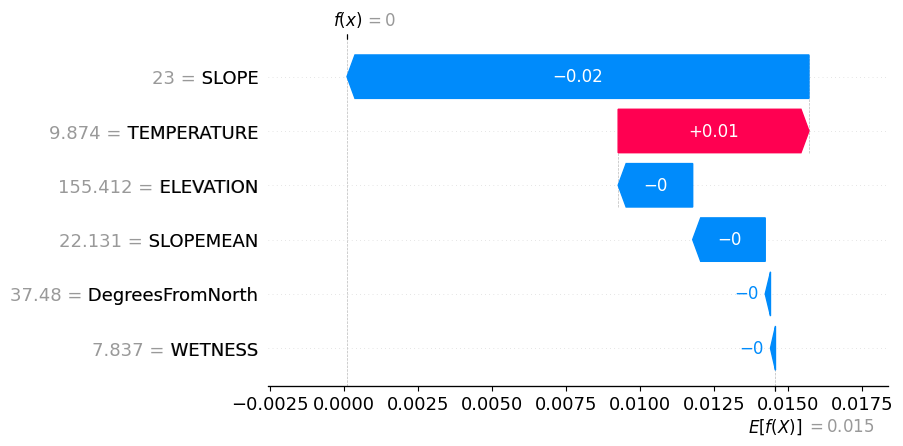

In [ ]:
#Visualize a single observation

explainer = shap.TreeExplainer(model_regressor)
shap_values = explainer(X_test)

#This compares how much each feature for the observation pushes the model from the base value (mean prediction of the target)
i = 50
shap.plots.waterfall(shap_values[i], max_display=10)

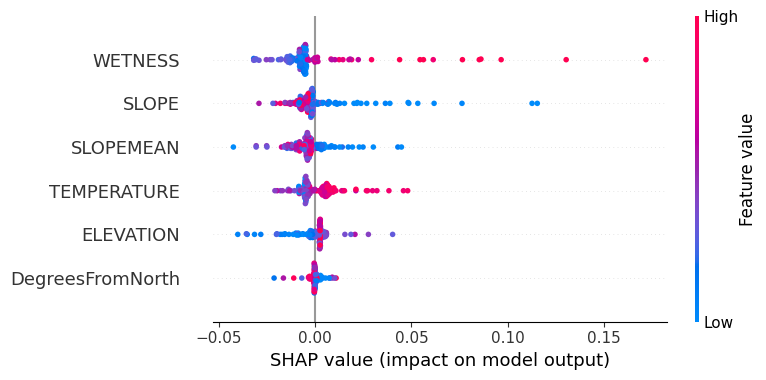

In [ ]:

RMSE = ('RMSE: {:.2f}'.format(rmse))
R2 = ('R2: {:.2f}'.format(r2))

shap.summary_plot(shap_values, X_test, show=False)
plt.savefig((outputdata_dir + target + " " + RMSE + " " + R2 + '.png'), dpi = 1000 )

In [ ]:
shap_sum = np.abs(shap_values_).mean(axis=0)
importance_df = pd.DataFrame([X_test.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
4,WETNESS,0.013062
1,SLOPE,0.009789
2,SLOPEMEAN,0.008627
5,TEMPERATURE,0.007478
0,ELEVATION,0.005482
3,DegreesFromNorth,0.001982


In [ ]:
# shap.force_plot(expected_value, shap_values_, X_test)

In [ ]:
# top_inds = np.argsort(-np.sum(np.abs(shap_values_), 0))

# for i in range(10):
#   shap.dependence_plot(top_inds[i], shap_values_, X_test, interaction_index=top_inds[i])